In [1]:
import argparse
import numpy as np
from pprint import pprint
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torchvision import datasets, transforms
import os
from whitebox_utils import label_to_onehot, cross_entropy_for_onehot, pixelwise_euclidean_distance
import matplotlib.pyplot as plt

# 指定使用文泉驿微米黑（系统已识别的字体名称）
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  
# 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
tt = transforms.ToTensor()#转发为张量
tp = transforms.ToPILImage()#转换为图片


(-0.5, 383.5, 383.5, -0.5)

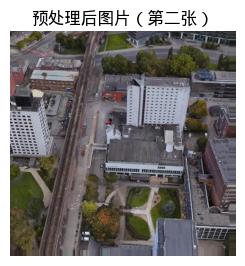

In [3]:
batchsize = 1
h, w = 384, 384
pad = 10

# 定义预处理流程
transform_list = [
    transforms.Resize((h, w), interpolation=3),
    transforms.Pad(pad, padding_mode='edge'),
    transforms.RandomCrop((h, w)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
data_transform = transforms.Compose(transform_list)

# 目标图片路径
target_path = '/mnt/workspace/RK-Net/data/University-Release/train/drone/0839'

# 验证路径是否存在
if not os.path.exists(target_path):
    raise FileNotFoundError(f"路径不存在: {target_path}")

# 加载指定路径下的图片
dataset = datasets.ImageFolder(
    root=os.path.dirname(target_path),
    transform=data_transform
)

# 过滤出目标子文件夹的样本
target_class = os.path.basename(target_path)
class_idx = dataset.class_to_idx[target_class]
filtered_indices = [i for i, (_, cls) in enumerate(dataset.imgs) if cls == class_idx]
dataset = torch.utils.data.Subset(dataset, filtered_indices)

# 检查图片数量是否足够
if len(dataset) < 2:
    raise ValueError(f"目标路径下照片数量不足2张，当前仅有{len(dataset)}张")

# 创建数据加载器
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batchsize,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 展示第二张照片（原始图片和预处理后图片）
# 1. 获取原始图片路径（未预处理）
# 注：dataset.imgs存储的是(图片路径, 类别)，需对应到过滤后的索引
original_img_path = dataset.dataset.imgs[filtered_indices[1]][0]  # 第二张图片的原始路径
original_img = Image.open(original_img_path).convert('RGB')  # 打开原始图片

# 2. 获取预处理后的图片（通过数据集索引获取）
preprocessed_img, label_image = dataset[3]  # 第二张图片（索引1）的预处理结果
# 转换为可显示格式（反归一化+转PIL）
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
preprocessed_img = inv_normalize(preprocessed_img)  # 反归一化
preprocessed_img = transforms.ToPILImage()(preprocessed_img)  # 转为PIL图片

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img)
plt.title('预处理后图片（第二张）')
plt.axis('off')

torch.Size([1, 3, 384, 384])


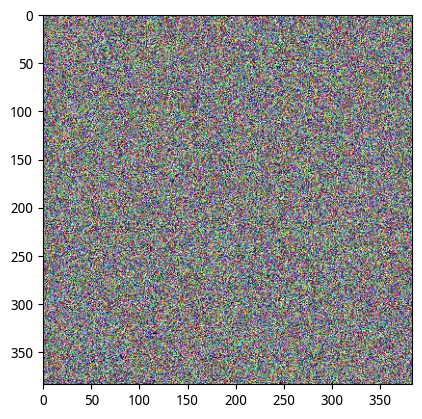

In [4]:

# 转换为batch格式（添加batch维度，模型通常需要[batch, c, h, w]格式）
preprocessed_img_torch = tt(preprocessed_img)
preprocessed_img_torch = preprocessed_img_torch.unsqueeze(0)  # 形状从[c, h, w]变为[1, c, h, w]
label_image_torch = torch.tensor([label_image])  # 标签添加batch维度

# 数据移至GPU（若使用）
print(preprocessed_img_torch.shape)
preprocessed_img = tp(preprocessed_img_torch[0])
dummy_data = torch.randn(*preprocessed_img_torch.size()).to(device).requires_grad_(True)  
dummy_label = torch.randn(label_image_torch.size()).to(device).requires_grad_(True)
plt.imshow(tp(dummy_data[0].cpu()))
plt.show()


In [5]:
# from model_white_attack import ft_net
# pretrained_path = '/mnt/workspace/RK-Net/RK-Net-main/model/pretrain/net_359.pth'  # 绝对路径
# # RK-Net/RK-Net-main/model/pretrain/net_359.pth
# model = ft_net(751).to(device)

# # 加载预训练权重（strict=False允许部分参数不匹配，适用于迁移学习）
# pretrained_state = torch.load(pretrained_path, map_location=torch.device('cpu'))
# model.load_state_dict(pretrained_state, strict=False)
# print("Loaded pretrained model from:", pretrained_path)

In [6]:

# from models.vision import weights_init
class VGG9(nn.Module):
    def __init__(self, num_classes, sp=4, in_channels=3, fig_size=384):####sp为切割点
        assert sp<=17 and sp>0
        super(VGG9, self).__init__()
        cfg = [32, 64, 128, 128, 256, 256, 512, 512]
        self.conv1 = nn.Conv2d(in_channels,  cfg[0], 3, 1, 1)
        self.conv2 = nn.Conv2d(cfg[0], cfg[1], 3, 1, 1)
        self.conv3 = nn.Conv2d(cfg[1], cfg[2], 3, 1, 1)
        self.conv4 = nn.Conv2d(cfg[2], cfg[3], 3, 1, 1)
        self.conv5 = nn.Conv2d(cfg[3], cfg[4], 3, 1, 1)
        self.conv6 = nn.Conv2d(cfg[4], cfg[5], 3, 1, 1)
        self.fc1   = nn.Linear(int((fig_size/8)**2)*cfg[5], cfg[6])
        self.fc2   = nn.Linear(cfg[6], cfg[7])
        self.fc3   = nn.Linear(cfg[7], num_classes)
        self.total_module_list = [self.conv1, self.conv2, nn.ReLU(), nn.MaxPool2d(2, 2), 
                                self.conv3, self.conv4, nn.ReLU(), nn.MaxPool2d(2, 2),
                                self.conv5, self.conv6, nn.ReLU(), nn.MaxPool2d(2, 2),
                               nn.Flatten(1), self.fc1, nn.ReLU(), self.fc2, nn.ReLU(), self.fc3]
        self.f = nn.Sequential(*self.total_module_list[0:sp])
        self.g = nn.Sequential(*self.total_module_list[sp:])

    def forward(self, x):
        x_1 = self.f(x)
        x_cut = x_1.detach().clone()
        x_out = self.g(x_1)
        return x_out, x_cut

model = VGG9(num_classes=751).to(device)#模型名字


In [7]:
print(dummy_data.size())
print(dummy_label)
# 总变差函数,输入dummy图像
def _tensor_size(t):
    return t.size()[1]*t.size()[2]*t.size()[3]
def total_variation(x):
    batch_size = x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]
    count_h = _tensor_size(x[:,:,1:,:])
    count_w = _tensor_size(x[:,:,:,1:])
    h_tv = torch.pow(x[:,:,1:,:]-x[:,:,:h_x-1,:], 2).sum()
    w_tv = torch.pow(x[:,:,:,1:]-x[:,:,:,:w_x-1], 2).sum()
    return (h_tv / count_h + w_tv / count_w) / batch_size

# def loss_function_1(X_cut, X0_cut,tv, lambda_param=0.4):

#     euclidean_dist = pixelwise_euclidean_distance(X_cut, X0_cut)
    
#     return euclidean_dist + lambda_param * tv

torch.Size([1, 3, 384, 384])
tensor([1.6883], device='cuda:0', requires_grad=True)


In [8]:
#optimizer.zero_grad()  # 清空梯度
torch.manual_seed(1234)
print(dummy_data.shape)
print(preprocessed_img_torch.shape)
preprocessed_img_torch = preprocessed_img_torch.to(device)
dummy_data = dummy_data.to(device)
# compute original gradient 
# _, original_cut = model(preprocessed_img_torch)
original_cut = model.f(preprocessed_img_torch)
ture_cut= original_cut.detach().clone()
#print(original_cut)
# original_loss = criterion(pred, gt_onehot_label)
# dy_dx = torch.autograd.grad(original_loss, net.parameters(), retain_graph=True)

#original_dy_dx = list((_.detach().clone() for _ in dy_dx))


torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])


In [9]:
print(original_cut.shape)

torch.Size([1, 64, 192, 192])


epoch is 0, and loss is 390.7325439453125 loss_1: 504.3406677246094 loss_2: 393.34161376953125, diff_cut: 389.79486083984375
epoch is 1000, and loss is 132.70803833007812 loss_1: 240.8562469482422 loss_2: 183.7228240966797, diff_cut: 132.2740936279297
epoch is 2000, and loss is 41.464263916015625 loss_1: 55.919525146484375 loss_2: 40.44462966918945, diff_cut: 41.36631393432617
epoch is 3000, and loss is 4.344566345214844 loss_1: 2.182555913925171 loss_2: 1.2725895643234253, diff_cut: 4.340981483459473
epoch is 4000, and loss is 0.7295242547988892 loss_1: 0.02175176329910755 loss_2: 0.15803280472755432, diff_cut: 0.7292311787605286
epoch is 5000, and loss is 0.7282520532608032 loss_1: 0.021792177110910416 loss_2: 0.15780161321163177, diff_cut: 0.727959156036377
epoch is 6000, and loss is 0.7284001708030701 loss_1: 0.0219455286860466 loss_2: 0.1579078584909439, diff_cut: 0.7281070351600647
epoch is 7000, and loss is 0.7286263108253479 loss_1: 0.021897530183196068 loss_2: 0.15805637836456

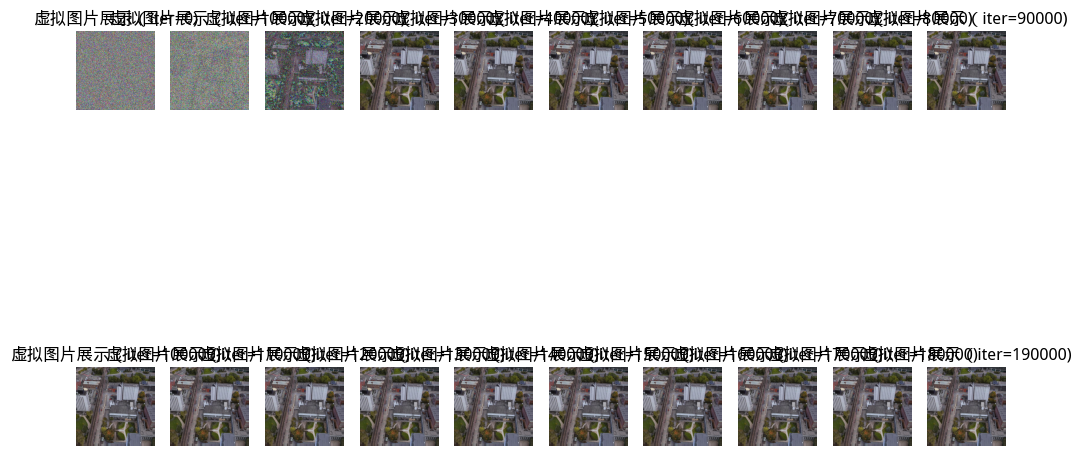

In [10]:
T = 20000
lr = 0.001
optimizer = torch.optim.Adam([dummy_data], lr=lr)
# range_T = tqdm(range(1, T+1), desc="White-box attacking...")
epsilon=1e-6
l0 = 1e-3
l1 = 0.01
l2 = 1e-3
history = []


for iters in range(T):
    optimizer.zero_grad()  # 清空梯度
        # 使用网络对虚拟数据进行预测
    # _, dummy_cut = model(dummy_data)
    dummy_cut = model.f(dummy_data)
    tv = total_variation(dummy_data)
    diff_cut = torch.norm((dummy_cut[ture_cut.abs()>epsilon]- ture_cut[ture_cut.abs()>epsilon]), p=2)
    loss_1 = torch.norm(dummy_data-torch.clamp(dummy_data, min=0, max=1))
    loss_2 = torch.norm(dummy_cut[ture_cut.abs()<epsilon])
    dummy_loss = diff_cut +tv*l1+l0*loss_1 + l0*loss_2
        
        #dummy_dcut_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True, retain_graph=True, allow_unused=True)
    dummy_loss.backward()
    optimizer.step()  # 进行dummy_data参数更新
    #dummy_loss, dummy_dcut_dx = closure()
   
    if iters % 1000 == 0: ##打印损失
        print(f"epoch is {iters}, and loss is {dummy_loss} loss_1: {loss_1} loss_2: {loss_2}, diff_cut: {diff_cut}")
        #print(iters, "%.4f" % current_loss.item())
        history.append(tp(dummy_data[0].cpu()))
        
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(history[i])
    plt.title("虚拟图片展示（iter=%d)" % (i * 10000))
    plt.axis('off')

plt.show()


In [11]:
# print(dummy_loss)